# Interpolation Calanus multivariate
Interpolate (multivariate) the observations of _Calanus finmarchicus_ and _Calanus helgolandicus_, using the water temperature as a co-variable.

The fields are prepared over a region covering the Northeast Atlantic.      
Different resolutions are tested: 0.5° X 0.5°, 1° X 1° and 2° X 2°.

In order to modify the directories, the spatial resolution, edit the configuration file [config.jl](../src/config.jl).

## Procedure

The steps are:
- reading the data
- preparting the land/sea mask
- setting the analysis parameters
- perform the interpolation

In [51]:
using Dates
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot
using PyCall
include("../src/InterpCalanus.jl")
include("../src/config.jl")
@show pathof(DIVAnd)

[ Info: Workig at resoluton 0.25° X 0.25°
[ Info: Observation file already downloaded
[ Info: Bathymetry file already downloaded
[ Info: Temperature file already downloaded


pathof(DIVAnd) = "/home/ctroupin/.julia/packages/DIVAnd/MV3j9/src/DIVAnd.jl"


"/home/ctroupin/.julia/packages/DIVAnd/MV3j9/src/DIVAnd.jl"

## Files and directories
We need to have:
1. the temperature data
2. the CPR observations
3. the bathymetry.

The file `temperature_surface_WOD2.nc` contains all the temperature measurements in the region of interest and for a depth between 5 m and the sea surface. It was prepared with the notebook [`read_plot_WOD_data`](read_plot_WOD_data.ipynb).

## Domain, metrics, mask

In [35]:
longrid = domain[1]:dlon:domain[2]
latgrid = domain[3]:dlat:domain[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

[ Info: Size of the grid: 130 X 104
[ Info: (130, 104)


### Mask

In [36]:
_, _, mask = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, 5.0);

# Remove Med Sea
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

## Read the data
We will prepare monthly fields for given time periods.

In [57]:
yearmin = 2001
yearmax = 2001
imonth = 4

4

### Temperature

In [58]:
@time obsvalue, obslon, obslat, obsdepth, obstime, obsids = loadobs(Float64, temperaturefile, "Temperature");
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);
goodyear = (year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& (month_temperature .== imonth)
@info("Found $(sum(goodyear)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

  0.090513 seconds (286.40 k allocations: 69.447 MiB)


[ Info: Found 1015 observations for the period April 2001 - 2001


In [59]:
@time lonT, latT, depthT, timeT, dataT = obslon[goodyear], obslat[goodyear], obsdepth[goodyear], 
obstime[goodyear], obsvalue[goodyear];

  0.000071 seconds (6 allocations: 40.359 KiB)


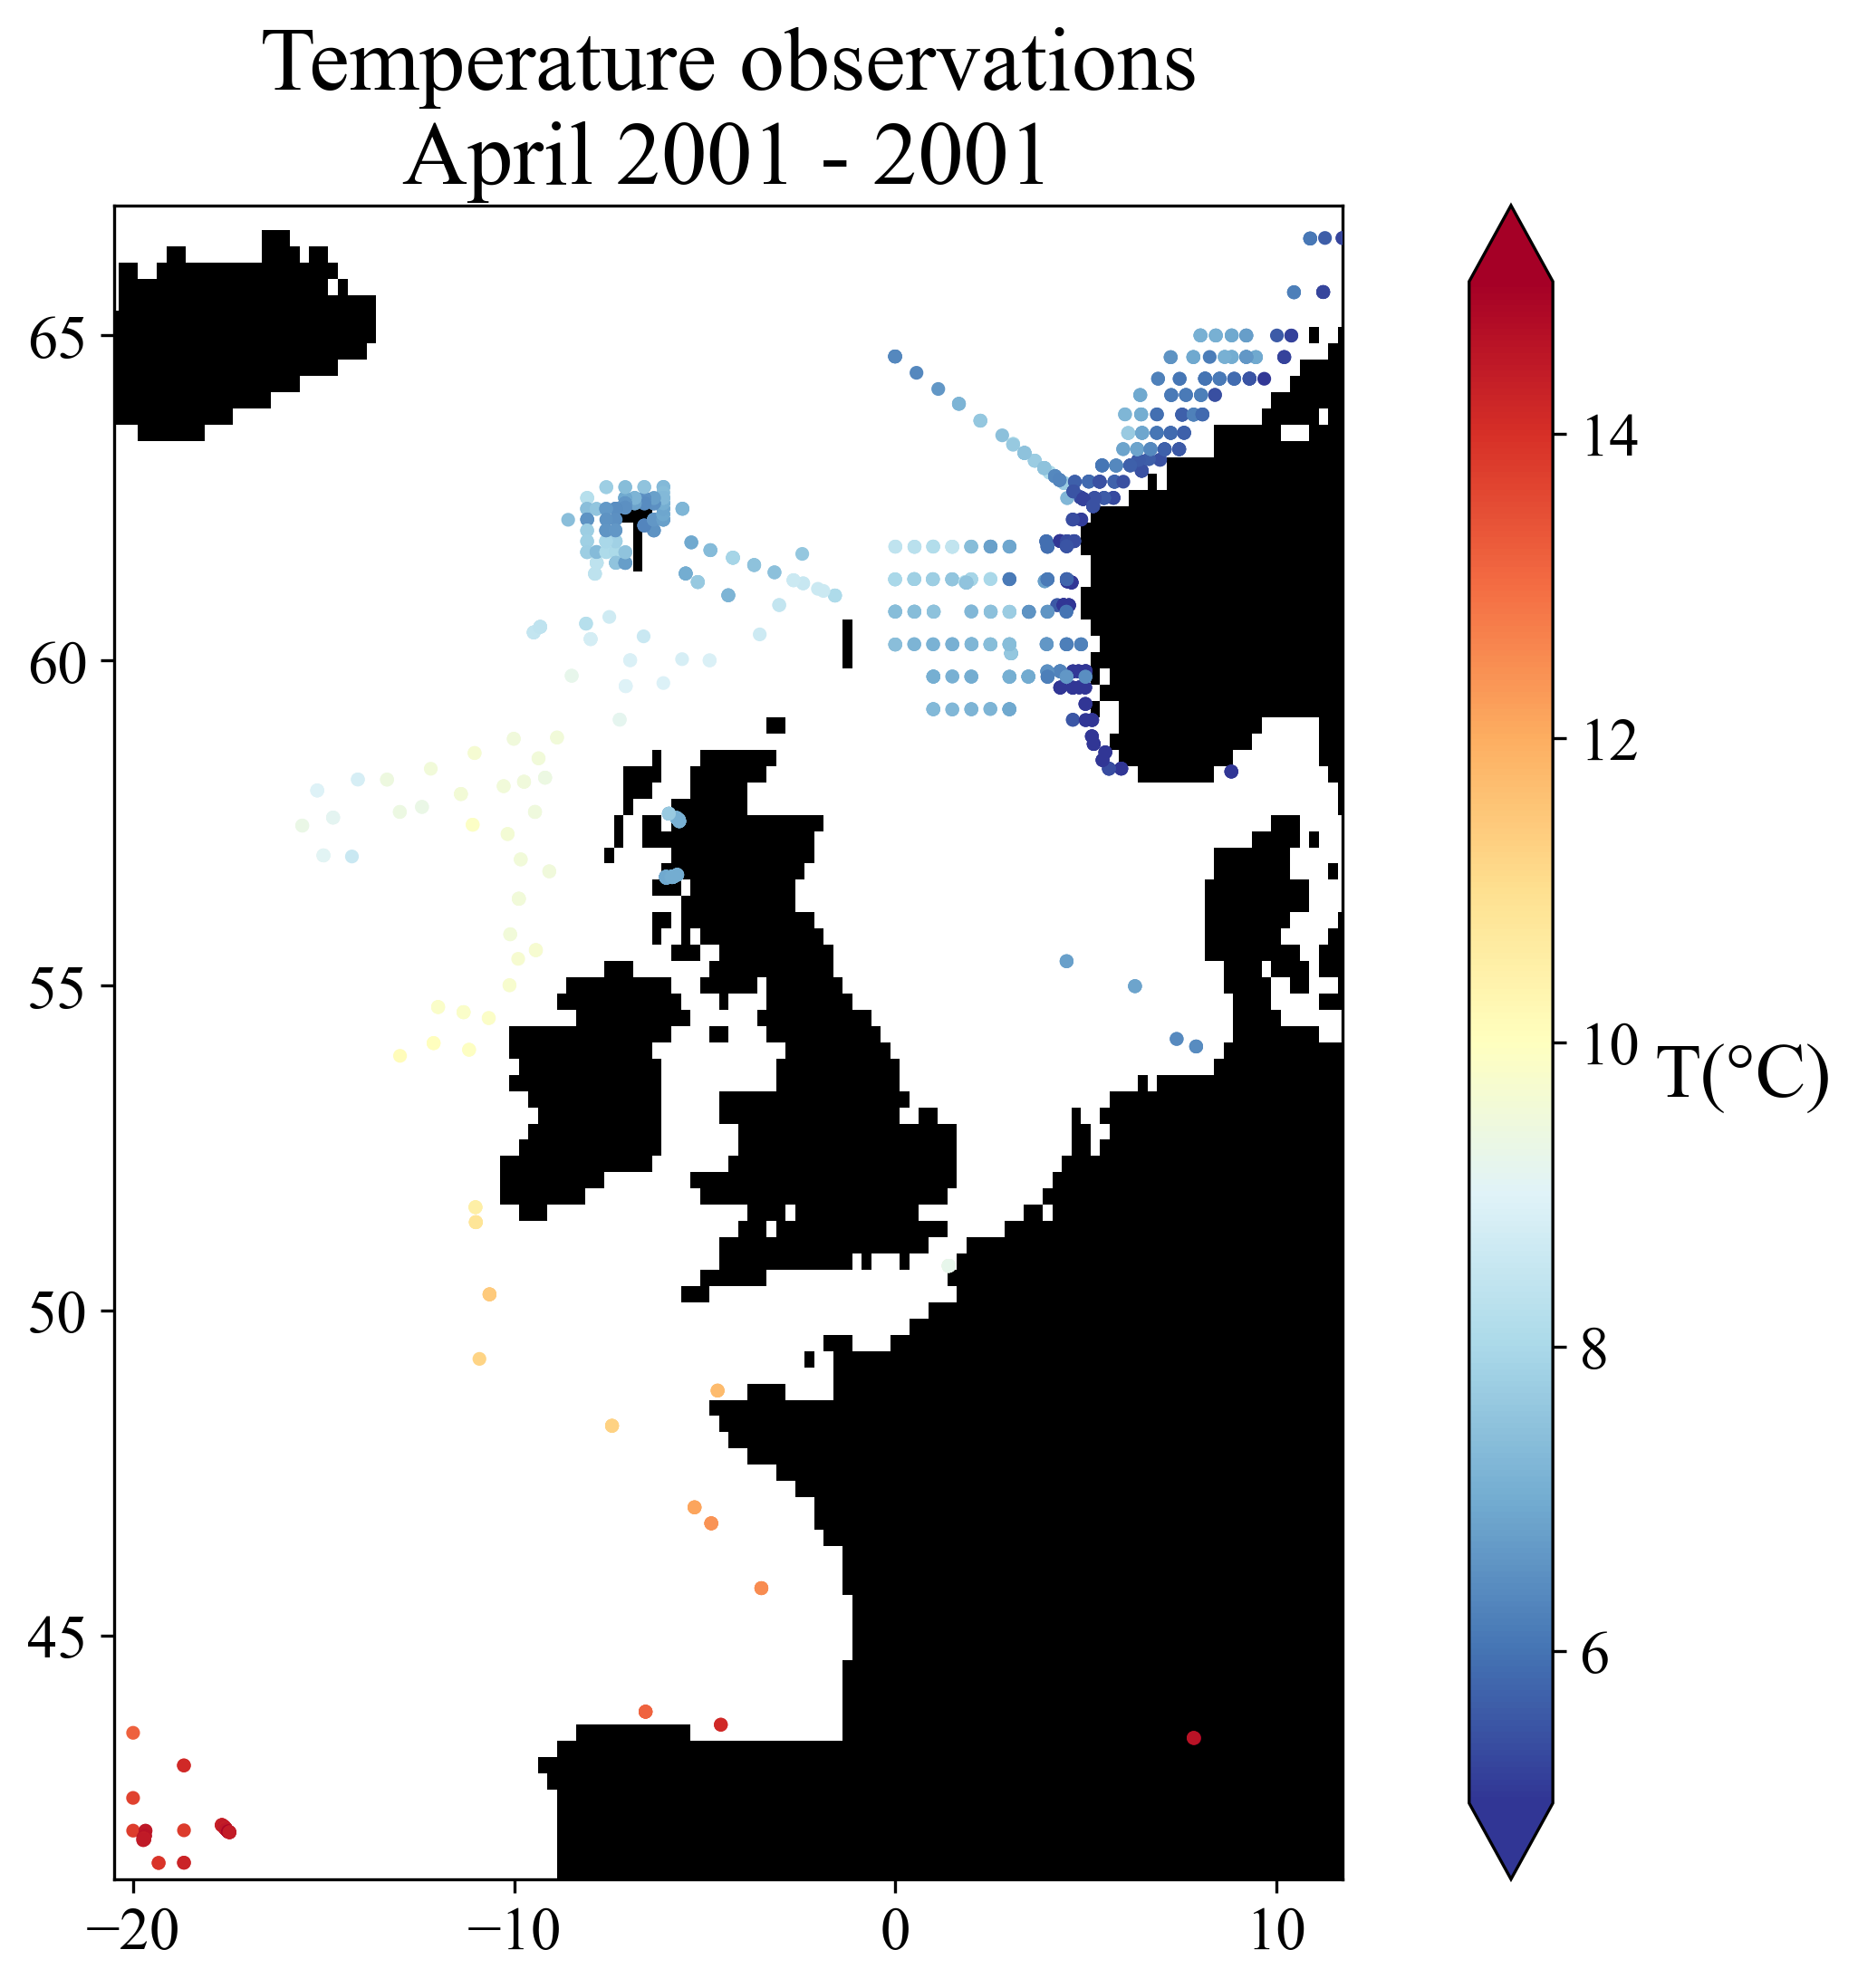

In [60]:
Tmin = 5.
Tmax = 15.

fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lonT, latT, s=7, c=dataT, cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="both")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb.set_label("T(°C)", rotation=0, ha="left")
ax.set_title("Temperature observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "WOD_temperature_200104"))
plt.show()

### Plankton

In [61]:
@time lon, lat, dates, calanus_finmarchicus, calanus_helgolandicus = InterpCalanus.read_data_calanus(datafile);

  0.439493 seconds (4.82 M allocations: 147.832 MiB, 48.02% gc time)


[ Info: (-20.447, 11.703)
[ Info: (41.2567, 66.808)


#### Subsetting

In [62]:
goodtimeCPR = (Dates.year.(dates) .>= yearmin ) .& (Dates.year.(dates) .<= yearmax) .& (Dates.month.(dates) .== imonth)
@info("Found plankton $(sum(goodtimeCPR)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

[ Info: Found plankton 261 observations for the period April 2001 - 2001


#### Make plot

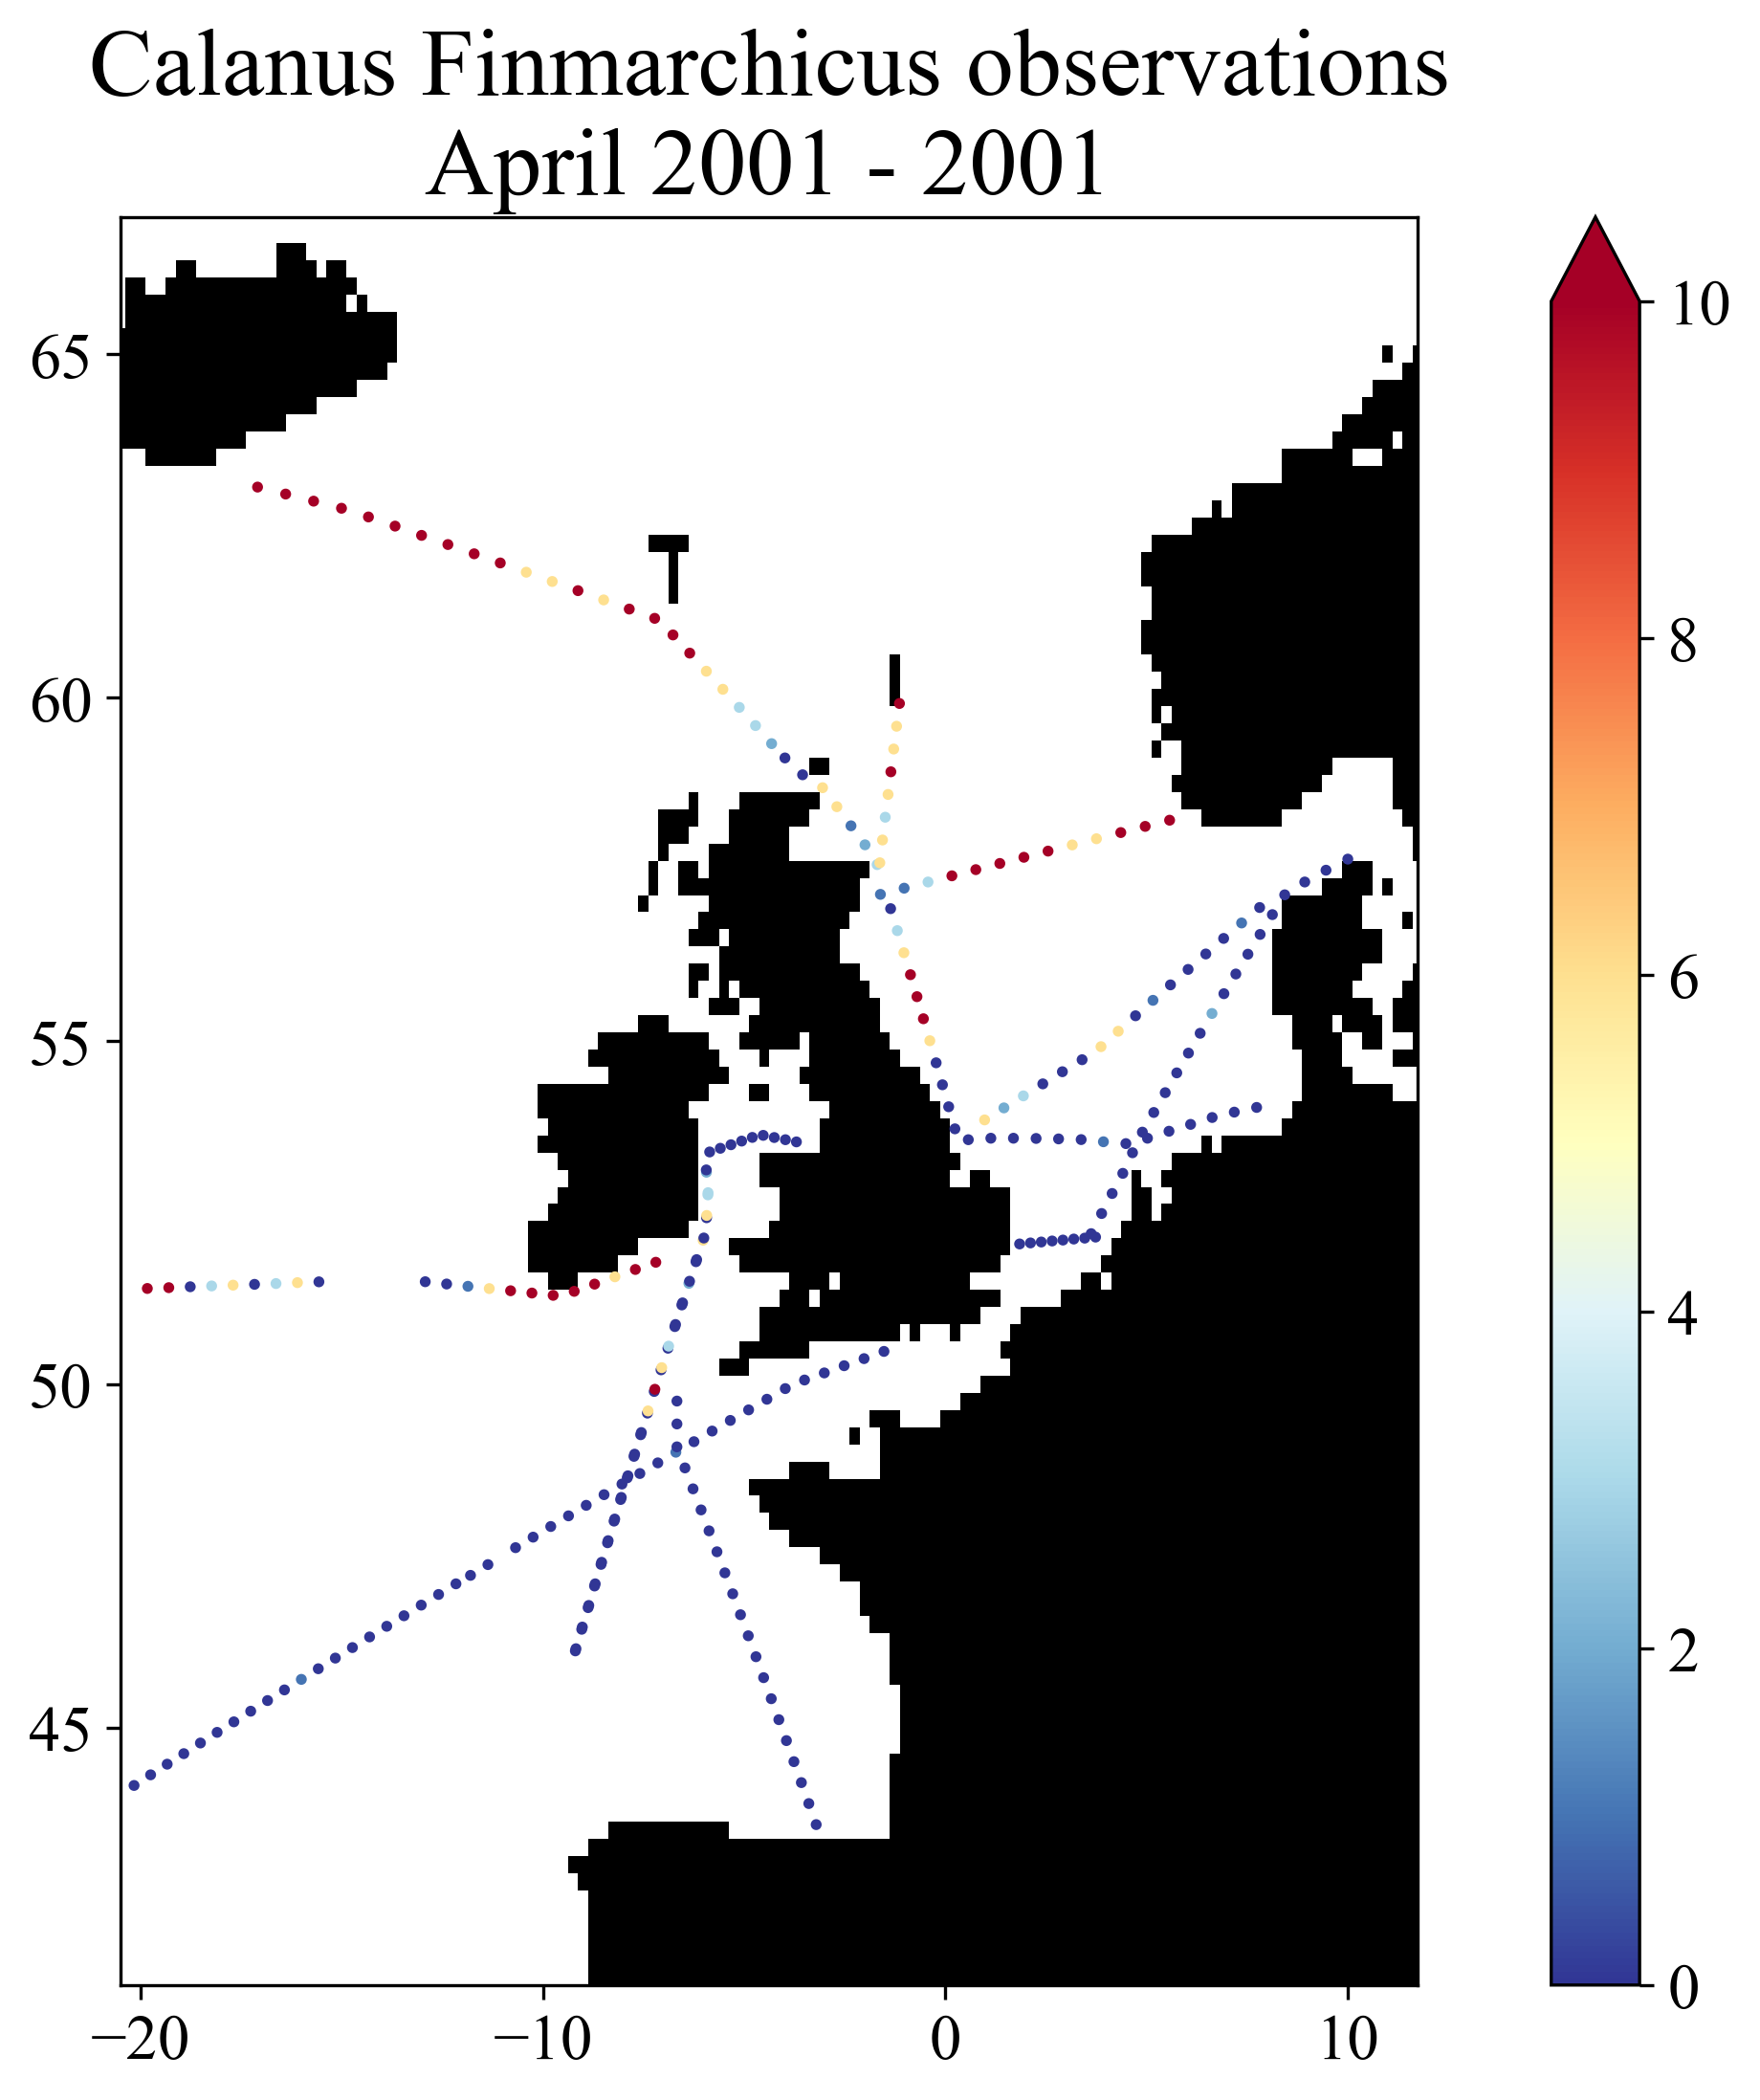

In [63]:
fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_finmarchicus[goodtimeCPR], 
    cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Finmarchicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_finmarchicus_200104"))
plt.show()

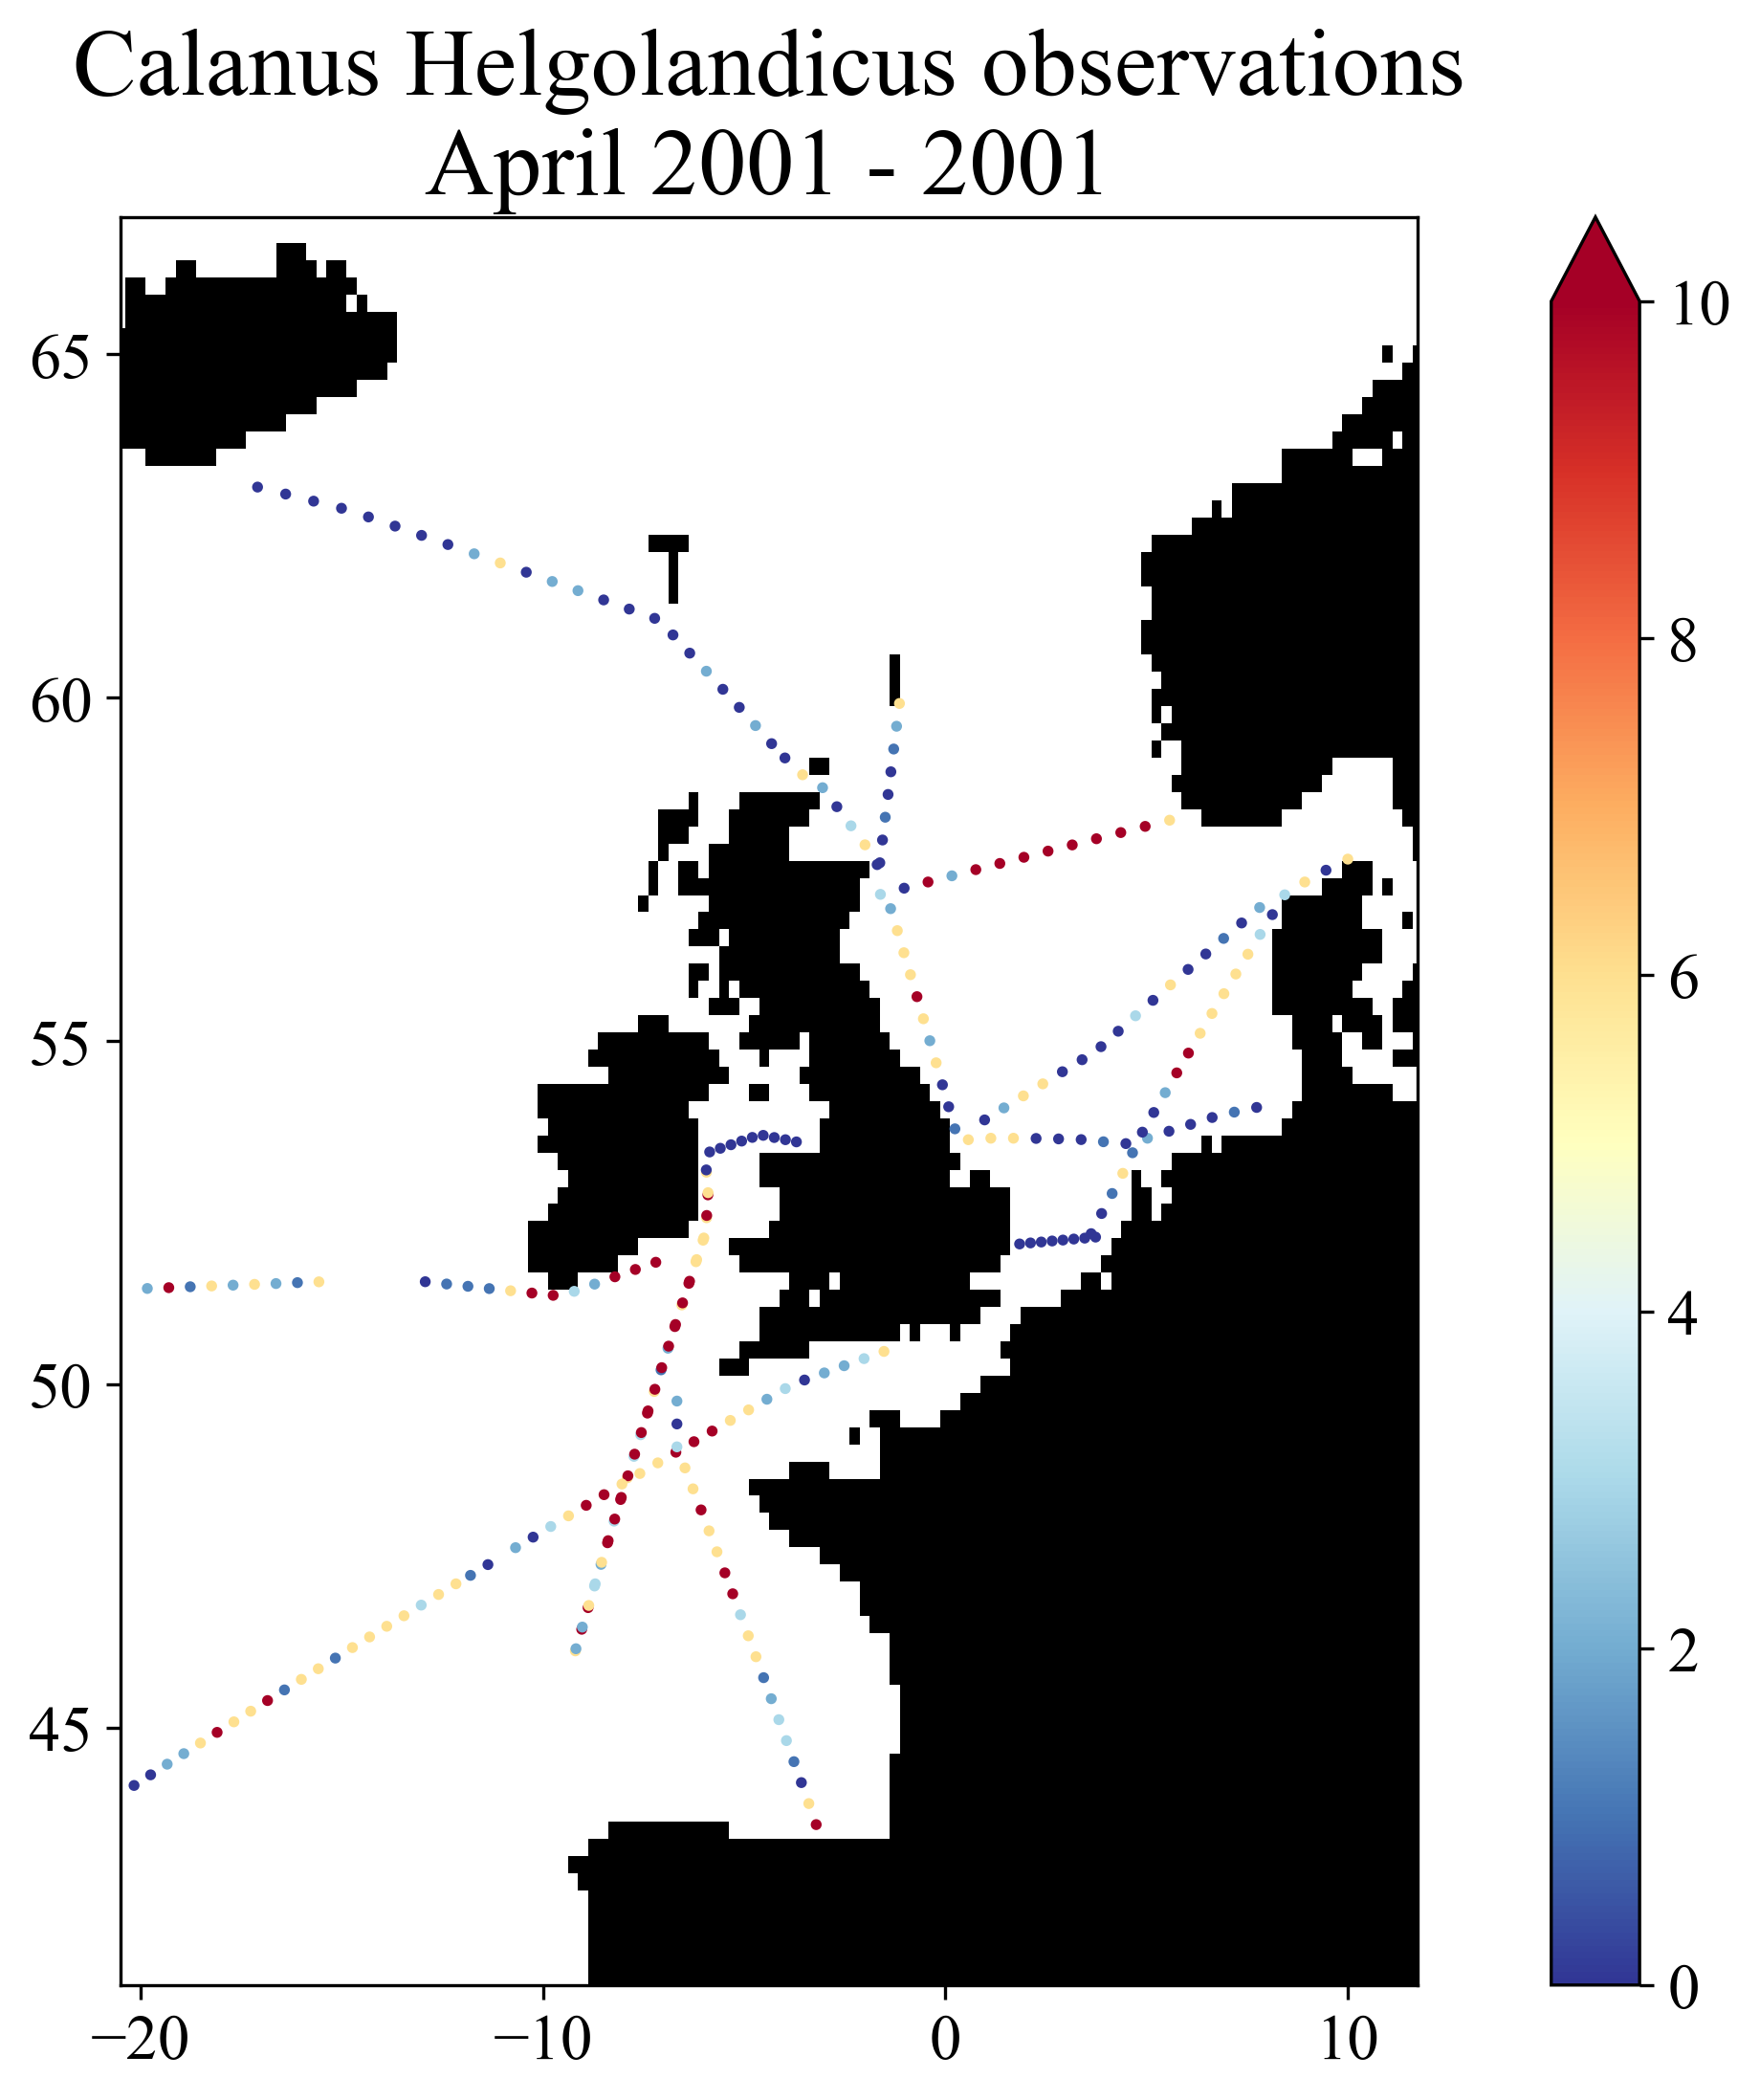

In [65]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_helgolandicus[goodtimeCPR], 
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Helgolandicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_helgolandicus_200104"))
plt.show()

## Univariate analysis
### Parameters

In [66]:
L = 2.5
epsilon2 = 5.

5.0

### Monovariate

In [67]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_finmarchicus[goodtimeCPR] .- 0. * mean(calanus_finmarchicus[goodtimeCPR]), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_helgolandicus[goodtimeCPR] .- 0. * mean(calanus_helgolandicus[goodtimeCPR]), (L, L), epsilon2);
@time T_interp, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lonT, latT), 
    dataT .- 1. * mean(dataT), (L, L), epsilon2);

  0.070262 seconds (6.14 k allocations: 118.624 MiB, 43.43% gc time)
  0.045136 seconds (6.14 k allocations: 118.624 MiB)
  0.059060 seconds (2.74 k allocations: 119.204 MiB, 43.95% gc time)


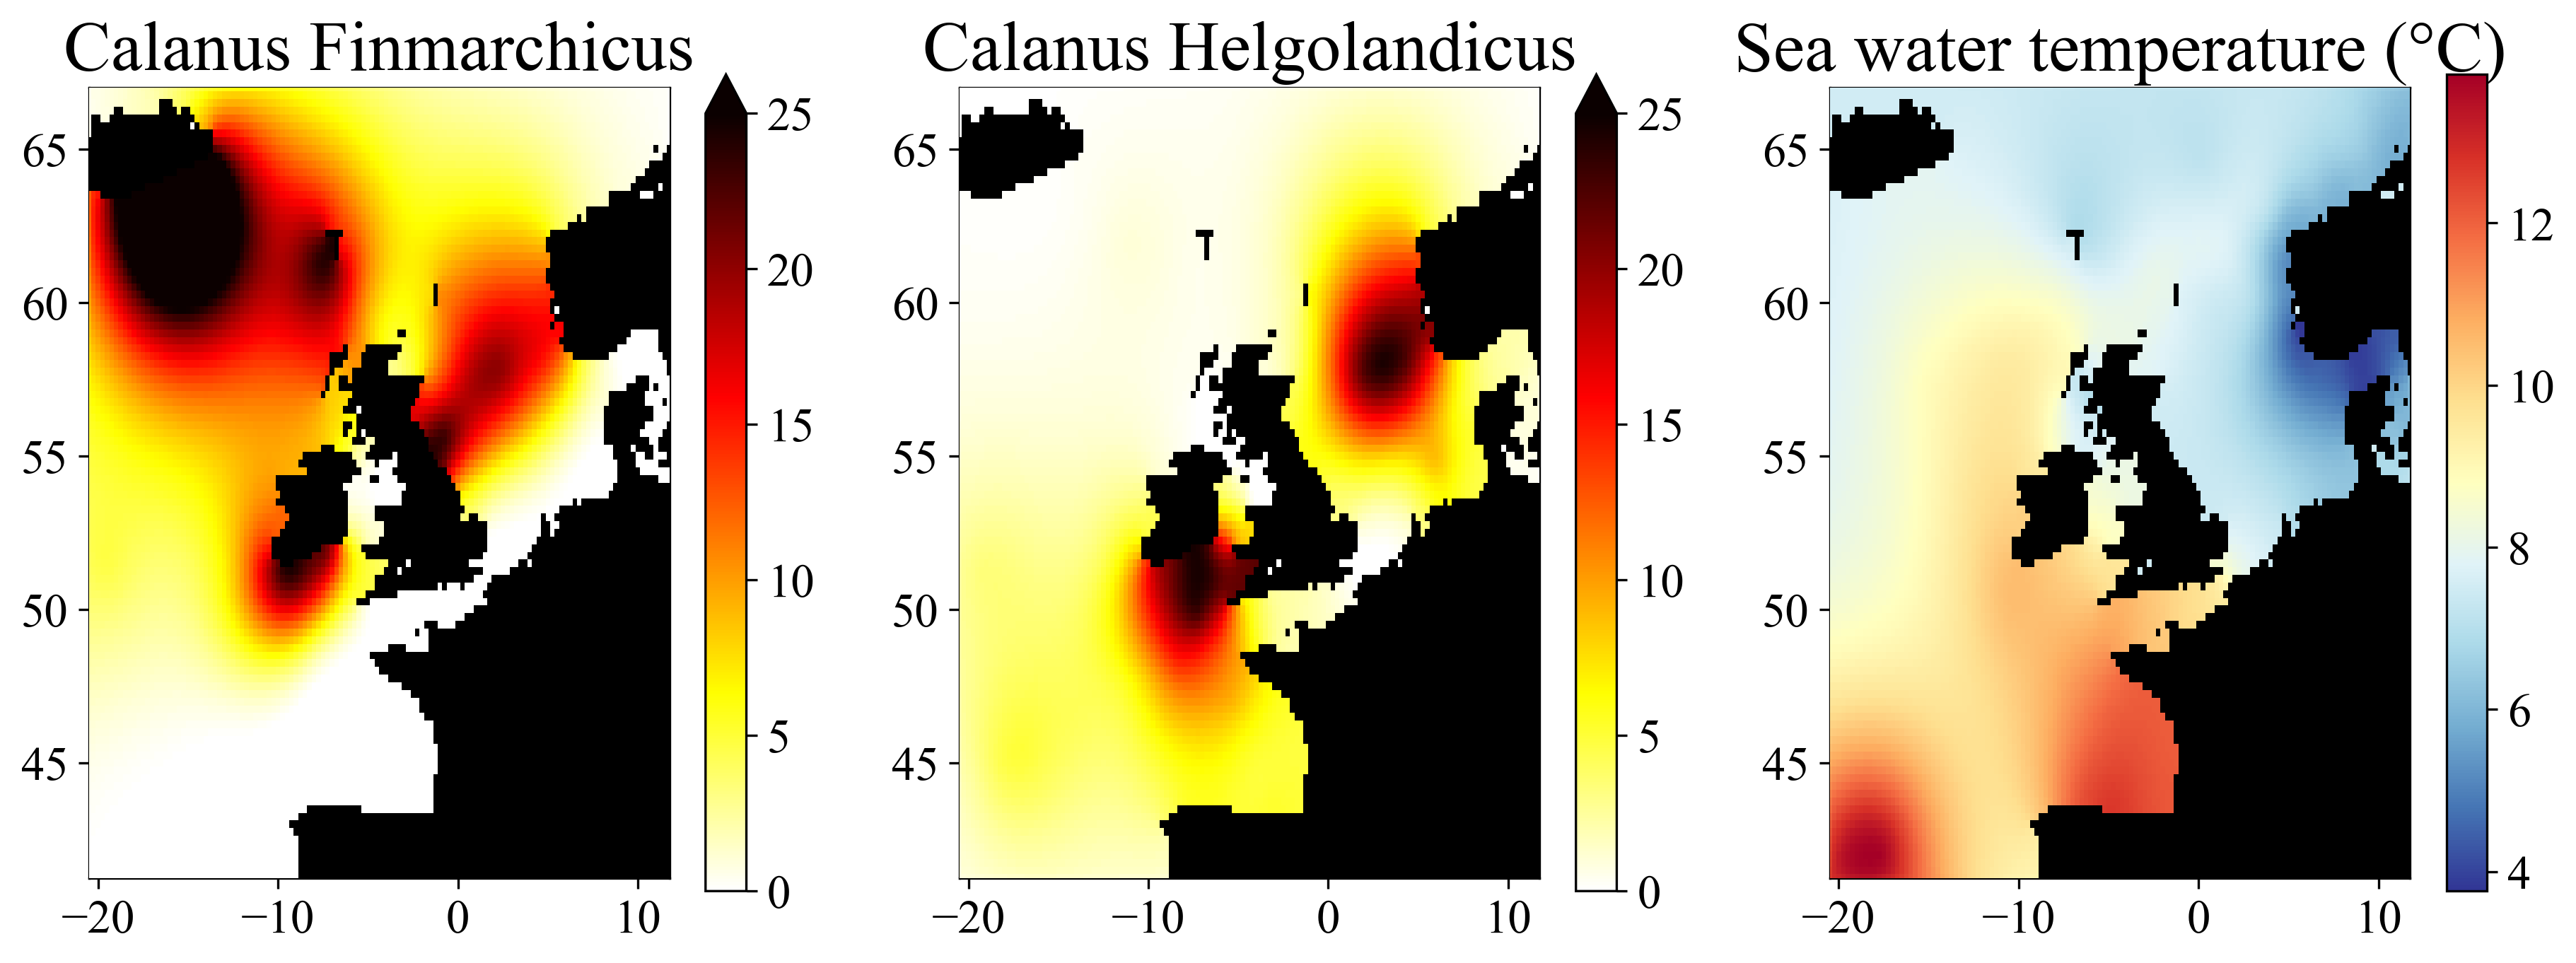

In [68]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi, yi, f_finmarchicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi, yi, f_helgolandicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi, yi, T_interp .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

plt.show()

## Multivariate analysis
### Data preparation
1. Concatenate all the coordinate and observation vectors
2. Normalise the variables
3. Create a new dimension `vvv` with value **1** for plankton data points and **2** for temperature observations.

In [85]:
calanus_finmarchicus_sel_mean = mean(calanus_finmarchicus[goodtimeCPR])
calanus_finmarchicus_sel_std = std(calanus_finmarchicus[goodtimeCPR])
calanus_helgolandicus_sel_mean = mean(calanus_helgolandicus[goodtimeCPR])
calanus_helgolandicus_sel_std = std(calanus_helgolandicus[goodtimeCPR])
T_mean = mean(dataT)
T_std = std(dataT)
calanus_finmarchicus_norm = (calanus_finmarchicus[goodtimeCPR] .- calanus_finmarchicus_sel_mean) ./ calanus_finmarchicus_sel_std
calanus_helgolandicus_norm = (calanus_helgolandicus[goodtimeCPR] .- calanus_helgolandicus_sel_mean) ./ calanus_helgolandicus_sel_std
T_norm = (dataT .- T_mean) ./ T_std;

In [128]:
lonmulti = vcat(lon[goodtimeCPR], lonT)
latmulti = vcat(lat[goodtimeCPR], latT)
obsmulti_finmarchicus = vcat(Float64.(calanus_finmarchicus[goodtimeCPR]), dataT)
obsmulti_helgolandicus = vcat(Float64.(calanus_helgolandicus[goodtimeCPR]), dataT)
vvv = vcat(ones(length(goodtimeCPR)), 2 * ones(length(lonT)));

In [129]:
obsmulti_finmarchicus

1276-element Vector{Float64}:
 2.0
 2.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.0
 0.0
 ⋮
 7.247000217437744
 7.245999813079834
 7.182000160217285
 7.170000076293945
 7.159999847412109
 7.1620001792907715
 7.159999847412109
 7.127999782562256
 6.938000202178955
 6.926000118255615
 6.934999942779541
 6.934999942779541

### Create metrics and mask

In [130]:
maskmulti, (pm, pn, pv), (xi, yi, vi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid, 1:2);
maskmulti[:,:,1] = mask;
maskmulti[:,:,2] = mask;

### Perform analysis

In [131]:
@time fi1,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0), epsilon2);

@time fi2,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

  0.120976 seconds (26.93 k allocations: 287.374 MiB, 25.91% gc time)
  0.107429 seconds (26.93 k allocations: 287.374 MiB, 12.97% gc time)


In [137]:
vvv

147173-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

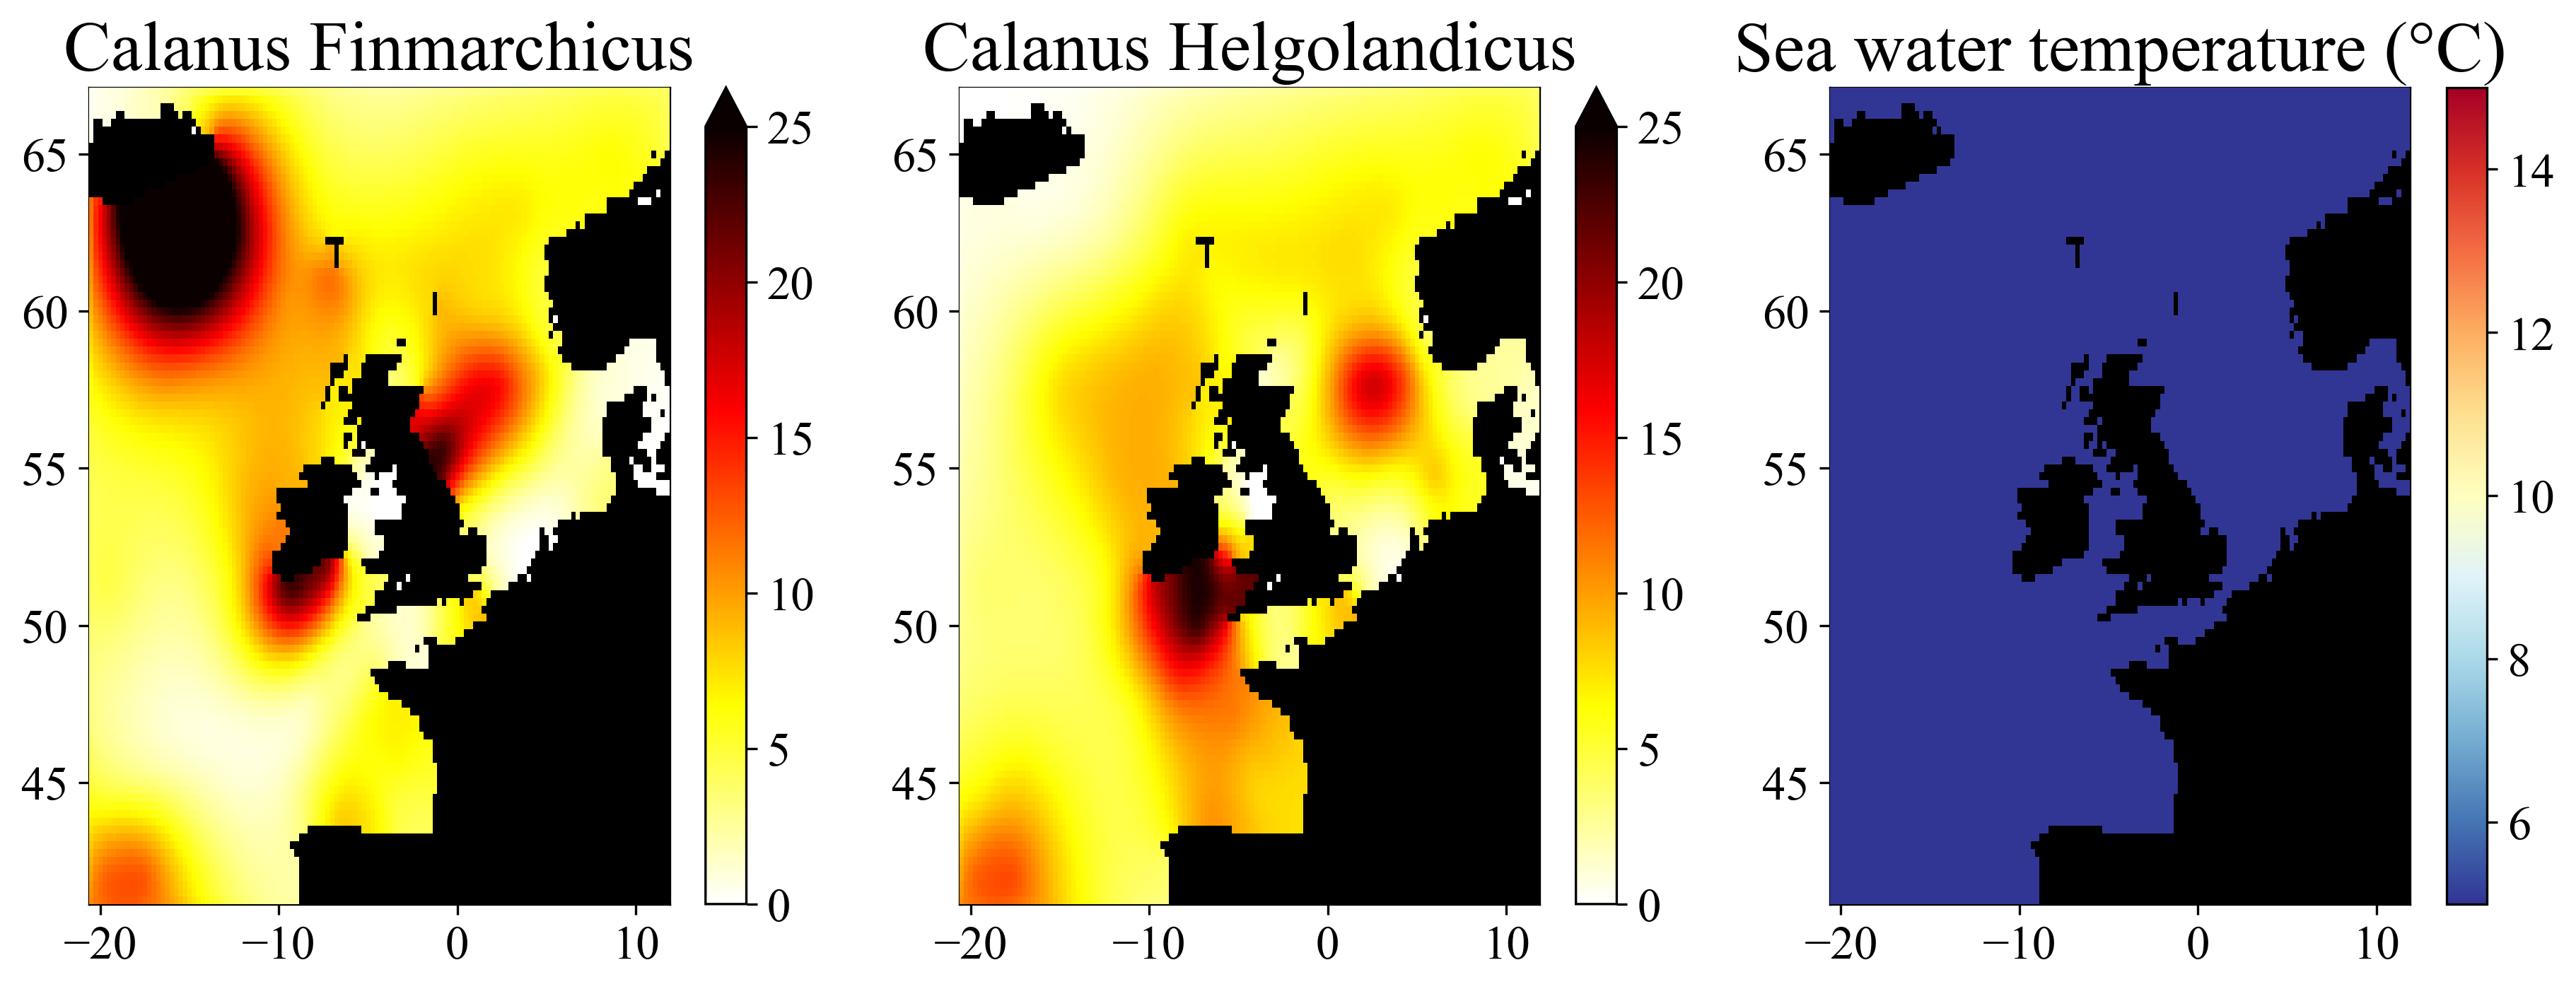

In [134]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fi1[:,:,1], 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fi2[:,:,1], 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1],
    fi2[:,:,2], 
    cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "monovariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

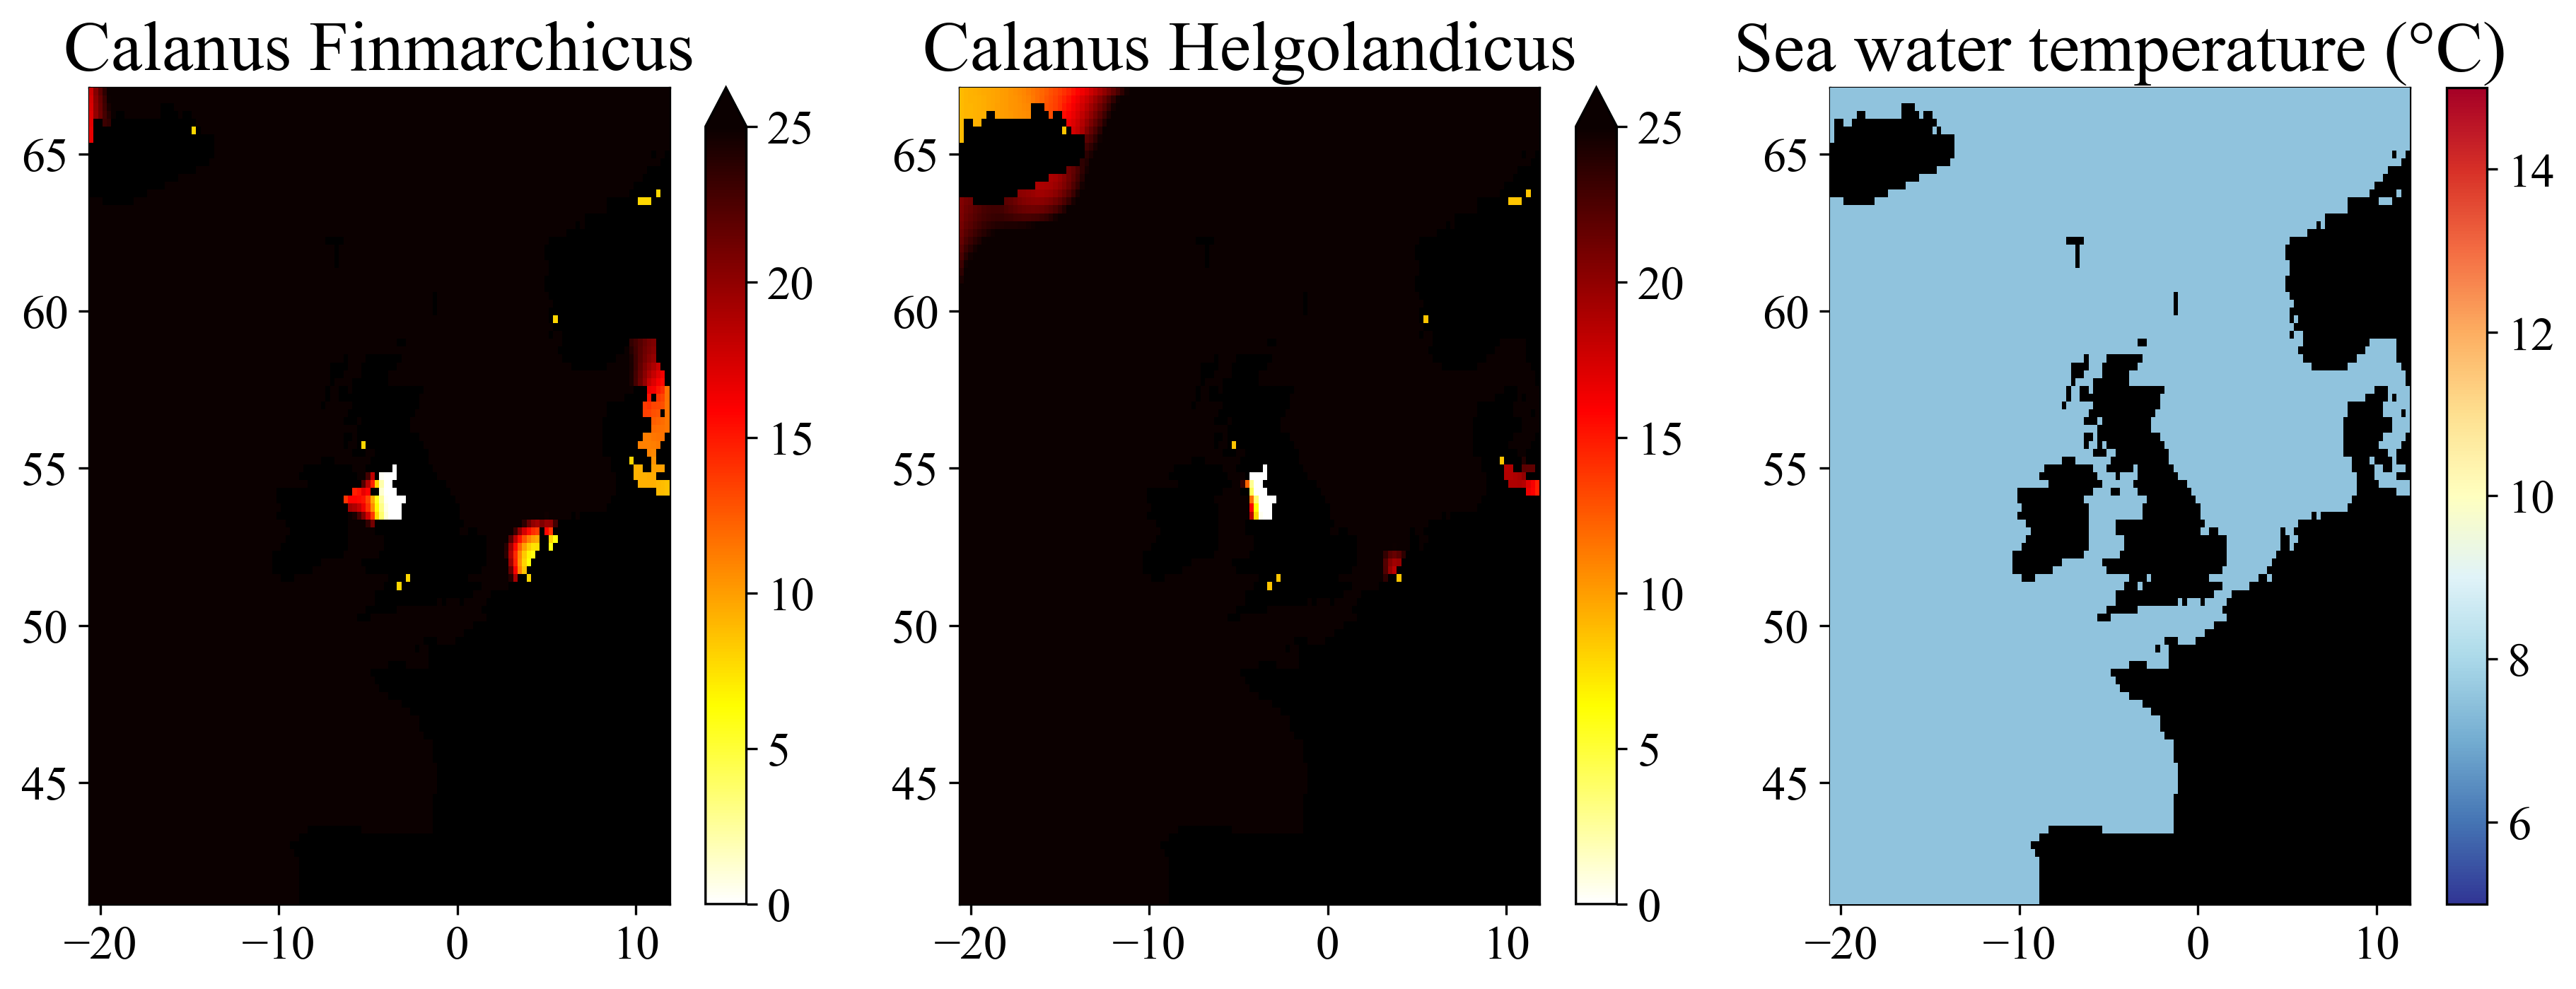

In [132]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fi1[:,:,1] .* 1. calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fi2[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1],
    (fi2[:,:,2] .* T_std) .+ T_mean, 
    cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "monovariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

### Some tests if we get it right
The 1st _component_ of the multivariate gridded fields should be the same as those obtained with the univariate analysis.         
The 2nd _component_ should be the temperature analysis.

In [109]:
using Test

In [110]:
@test fi1[mask,1] == f_finmarchicus[mask]
@test fi2[mask,1] == f_helgolandicus[mask]
@test fi1[mask,2] == fi2[mask,2]
@test fi1[mask,2] == T_interp[mask]

Test Failed at In[110]:1
  Expression: fi1[mask, 1] == f_finmarchicus[mask]
   Evaluated: [2.21348563200479, 2.348212015669724, 2.416158905420482, 2.4778516373351156, 2.5306044240684145, 2.572795391206226, 2.603541773656329, 2.6222917659196407, 2.6285132550295938, 2.6216684829571375  …  -0.3625758868433699, -0.3858810542979751, -0.4089248655121932, -0.4313404367527453, -0.4527714948631839, -0.47289649930922484, -0.4914589399597622, -0.5083090204787046, -0.5234487271999448, -0.5493452521045077] == [-0.008097926026344297, -0.024133093715418535, -0.03290712328552759, -0.04195931337898224, -0.0512368959990297, -0.06069233133183281, -0.07028450197692407, -0.07997939189312926, -0.08975028052361343, -0.0995775153660171  …  0.4029260367441396, 0.37429995836534546, 0.34683594843168164, 0.3205127420852196, 0.29530843950256996, 0.27120268654062807, 0.24817822172790707, 0.22622156493037557, 0.20532296902213365, 0.1676138353666484]


LoadError: [91mThere was an error during testing[39m

## Multivariate analysis
### EOF approach

In [118]:
@time fim1, s1, eof1, eofamplitudes1, emap1, emapm1 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 .*L), epsilon2);

LoadError: BoundsError: attempt to access 1276-element Vector{Float64} at index [147173-element BitVector]

In [22]:
size(emap1), size(emapm1)

LoadError: UndefVarError: emap1 not defined

In [23]:
@time fim2, s2, eof2, eofamplitudes2, emap2, emapm2 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 .*L), epsilon2);

LoadError: UndefVarError: lonmulti not defined

#### Plot the gridded fields

In [24]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1[:,:,1] .* calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1[:,:,2] .* dataT_std) .+ mean(dataT), cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
plt.savefig(joinpath(figdir, "multivariate_eof.png"), dpi=300, bbox_inches="tight")

plt.show()

LoadError: UndefVarError: fim1 not defined

### Jacobian approach

In [25]:
@time fim1Jac, s1, emap1, emapm1, pv1 = DIVAnd_multivarJAC(maskmulti, 
    (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

LoadError: UndefVarError: lonmulti not defined

In [26]:
@time fim2Jac, s2, emap2, emapm2, pv2 = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), 
    (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

LoadError: UndefVarError: lonmulti not defined

In [27]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1Jac[:,:,1] .* calanus_finmarchicus_sel_std) .+ calanus_finmarchicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2Jac[:,:,1] .* calanus_helgolandicus_sel_std) .+ calanus_helgolandicus_sel_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1Jac[:,:,2] .* dataT_std) .+ mean(dataT), 
    cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate_jac.png"), dpi=300, bbox_inches="tight")


plt.show()

LoadError: UndefVarError: fim1Jac not defined